This script plots the counts from fit and calculate flux, flux ratio 

In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs, scale_graph
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy_rebin, get_bin_center, Rigidity_Analysis_Binning_FullRange
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE,DETECTOR_LABEL 
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning 
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES, ISO_LABELS
import uproot
from tools.utilities import get_spline_from_graph, save_spline_to_file, get_graph_from_spline, get_spline_from_file


from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Reading data from files and setting constant variables

In [2]:
ALLNUCLEI = ['Be', 'Li', 'B']

datadirP8 = {'Be':'/home/manbing/Documents/Data/data_BeP8/presel_flux/',
             'Li':'/home/manbing/Documents/Data/data_LiP8/presel_flux/',
             'B':'/home/manbing/Documents/Data/data_BP8/presel_flux/'}
            
file_acc = {nuclei: datadirP8[nuclei] + f'{nuclei}MC_dict_graph_rawacc_RigidityP8.npz' for nuclei in ALLNUCLEI}
file_expotime = datadirP8['Be'] + 'expotime_p8rebin.root'

file_effcor = {nuclei: datadirP8[nuclei] + 'graph_total_effcor_presel.npz' for nuclei in ALLNUCLEI}

plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/LiBeBoronAverageFlux'
#plotfile = datadirP8
os.makedirs(plotfile, exist_ok=True)

detectors = ["Tof"]
#isotopes = ISOTOPES[nuclei]
isotopes_alias = {'Be7': 'be7', 'Be9': 'be9', 'Be10': 'be10'}
detectors_alias = {"Tof":"tof", "NaF":"naf", "Agl": "agl"} 
variable = 'Rigidity'
fig_suffix = 'P8'
slicevalue ={'Tof':[0.4185, 1.5473], 'NaF':[1.1666, 4.0029], 'Agl':[4.0029, 12.13]}
isrebin = False
xbinning = {'Ekin': Binning(fbinning_energy_rebin()), 'Rigidity': Binning(Rigidity_Analysis_Binning_FullRange())}
figname = '11yr'

244714731.46223804
/home/manbing/Documents/lithiumanalysis/slides/plots/LiBeBoronAverageFlux


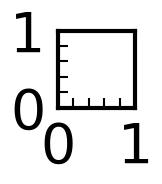

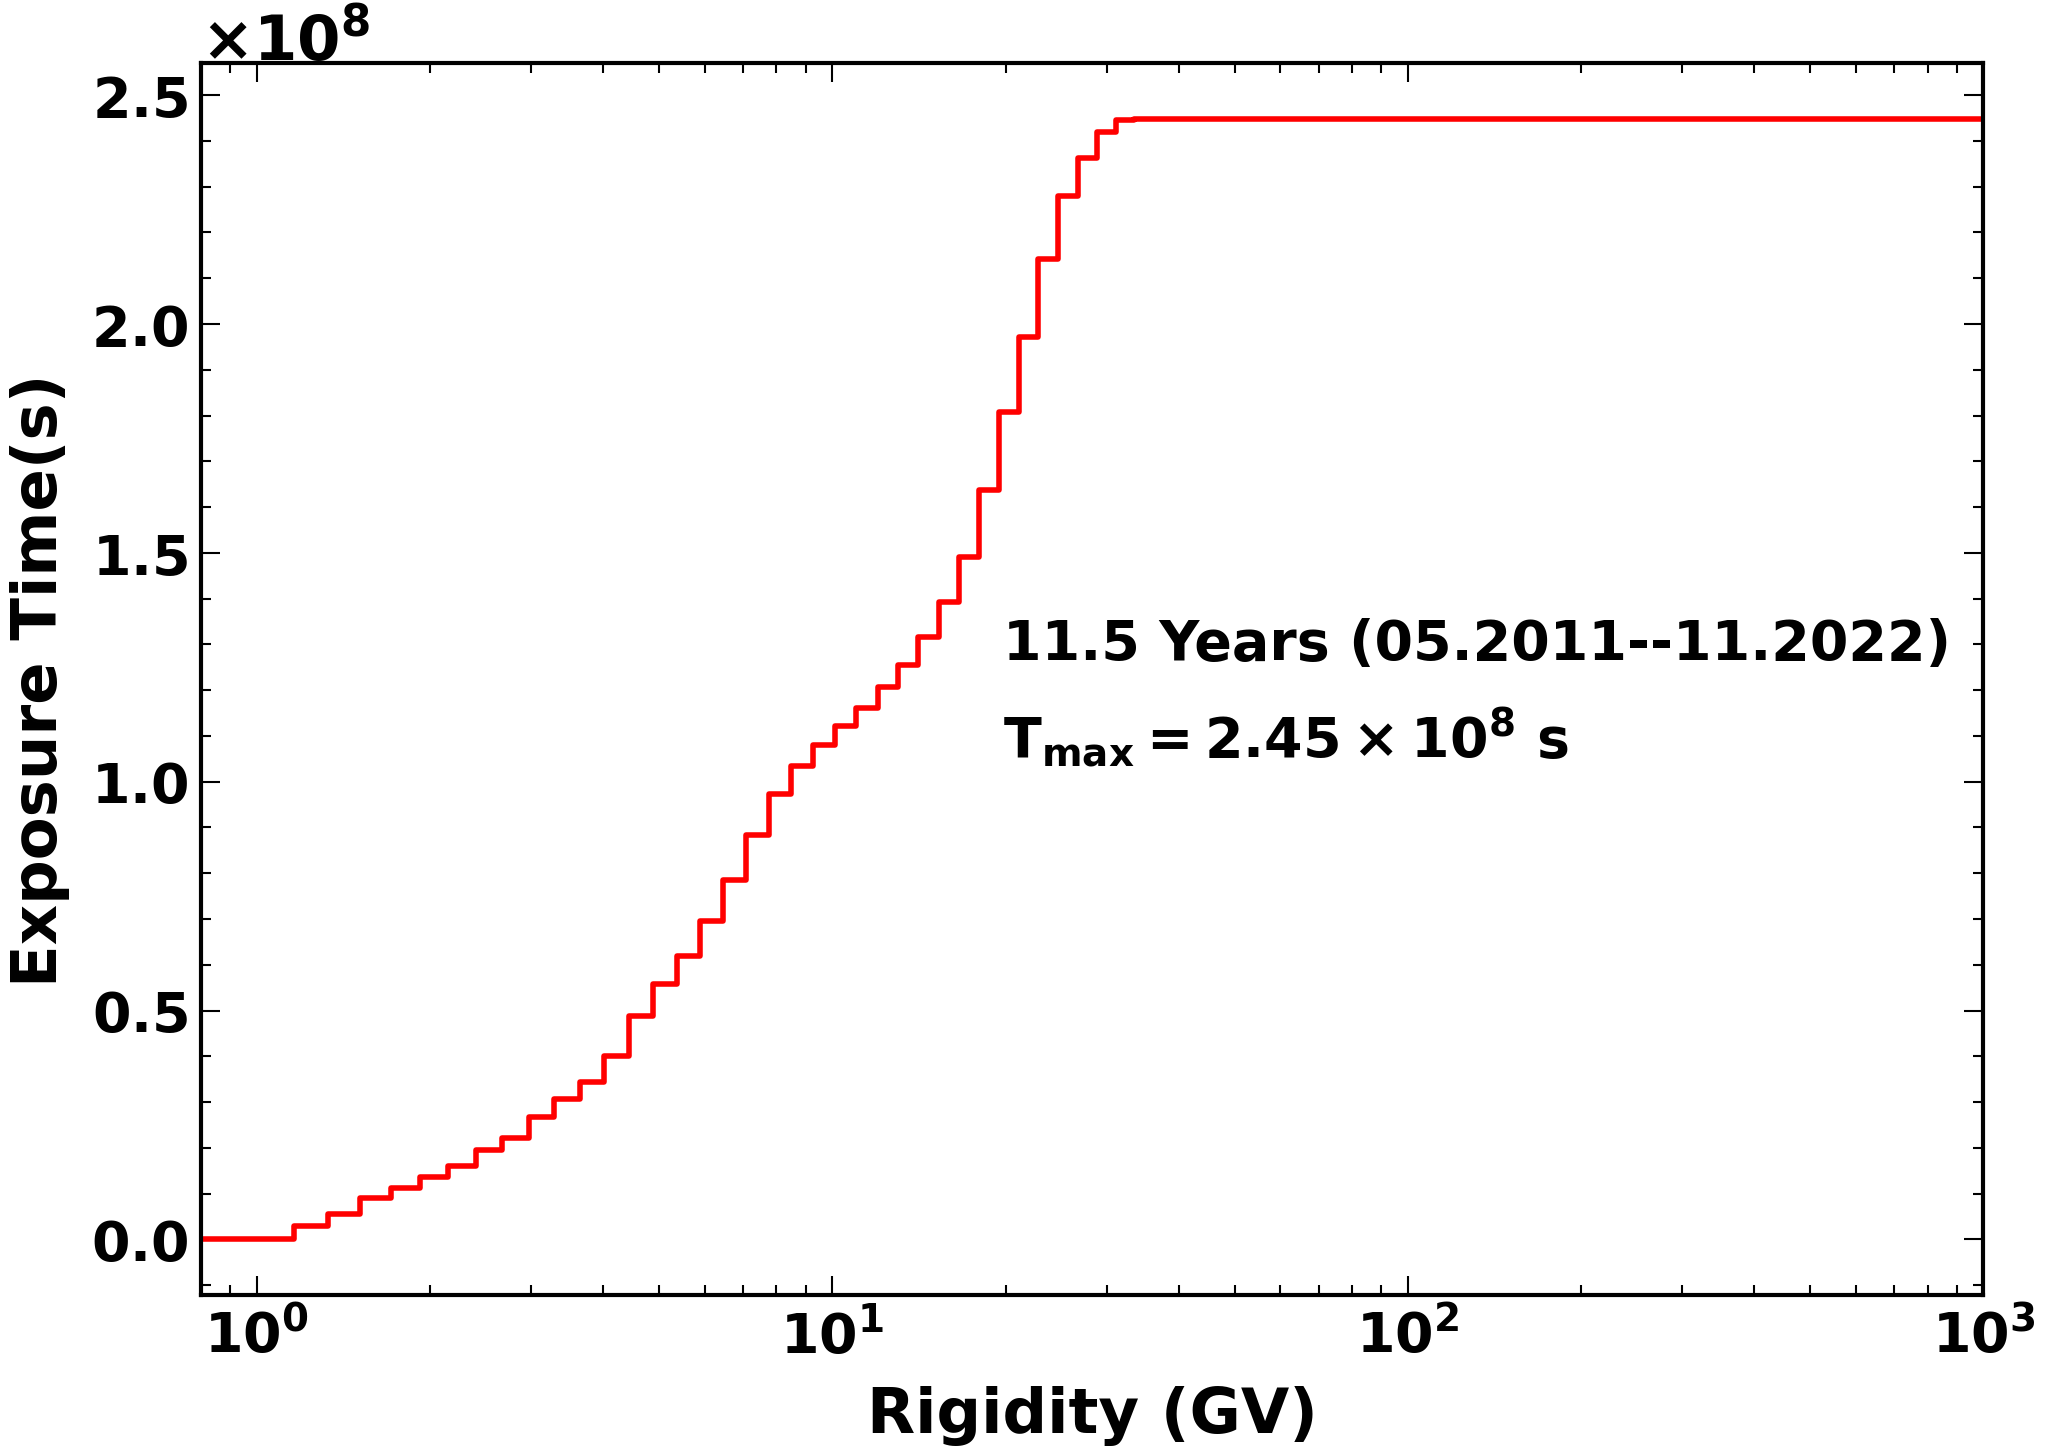

In [3]:
figure, ax1 = plt.subplots(1, 1, figsize=(1,1))
set_plot_style(ax1)
file_expotime = '/home/manbing/Documents/Data/data_BeP8/expotime/expotime_p8rebin.root'

This_COLOR = {'Be7': 'tab:blue', 'Be9': 'tab:green', 'Be10':'red'}
with uproot.open(file_expotime) as filetime:  
    hist_time = filetime[f'h_expo_sf_1']                                                                                                                                                   
    yexpotime = hist_time.values()                           
    xvalue_time = hist_time.axes[0].edges() 
    graph_measuretime = MGraph(get_bin_center(xvalue_time), yexpotime, np.zeros_like(yexpotime)) 
figure, ax1 = plt.subplots(1, 1, figsize=(23, 16))
                                                                                                                                                                                                                                                                                                                                                                   
plot1d_step(figure, ax1, hist_time.axes[0].edges(), hist_time.values(), err=None, label_x="Ek/n (GeV/n)", label_y="counts", legend=None, col=None, legendfontsize=18, setlogx=True, setlogy=False, setscilabelx=False, setscilabely=True, figsize=(12, 9),  tick_length=14, tick_width=1.5, color='red', linewidth=4)
ax1.set_xlim([0.8, 1000])
set_plot_style(ax1)
ax1.set_ylabel('Exposure Time(s)',fontsize=45, labelpad=15)
ax1.set_xlabel("Rigidity (GV)", fontsize=45, labelpad=15)
ax1.tick_params(axis='both', labelsize=40)
ax1.text(0.45, 0.55, '11.5 Years (05.2011--11.2022)', fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
print(max(hist_time.values()))
ax1.text(0.45, 0.48, r'$\mathrm{T_{max} = 2.45\times10^{8} \ s}$', fontsize=TEXTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
print(plotfile)
savefig_tofile(figure, plotfile, f"Be_measuring_time_vsR", 1)   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[    -inf 8.00e-01 1.00e+00 1.16e+00 1.33e+00 1.51e+00 1.71e+00 1.92e+00
 2.15e+00 2.40e+00 2.67e+00 2.97e+00 3.29e+00 3.64e+00 4.02e+00 4.43e+00
 4.88e+00 5.37e+00 5.90e+00 6.47e+00 7.09e+00 7.76e+00 8.48e+00 9.26e+00
 1.01e+01 1.10e+01 1.20e+01 1.30e+01 1.41e+01 1.53e+01 1.66e+01 1.80e+01
 1.95e+01 2.11e+01 2.28e+01 2.47e+01 2.67e+01 2.88e+01 3.11e+01 3.35e+01
 3.61e+01 3.89e+01 4.19e+01 4.51e+01 4.85e+01 5.22e+01 5.61e+01 6.03e+01
 6.48e+01 6.97e+01 7.49e+01 8.05e+01 8.65e+01 9.30e+01 1.00e+02 1.08e+02
 1.16e+02 1.25e+02 1.35e+02 1.47e+02 1.60e+02 1.75e+02 1.92e+02 2.11e+02
 2.33e+02 2.59e+02 2.91e+02 3.30e+02 3.79e+02 4.41e+02 5.25e+02 6.60e+02
 8.80e+02 1.30e+03 3.30e+03      inf]
2378862.0
/home/manbing/Documents/lithiumanalysis/slides/plots/LiBeBoronAverageFlux


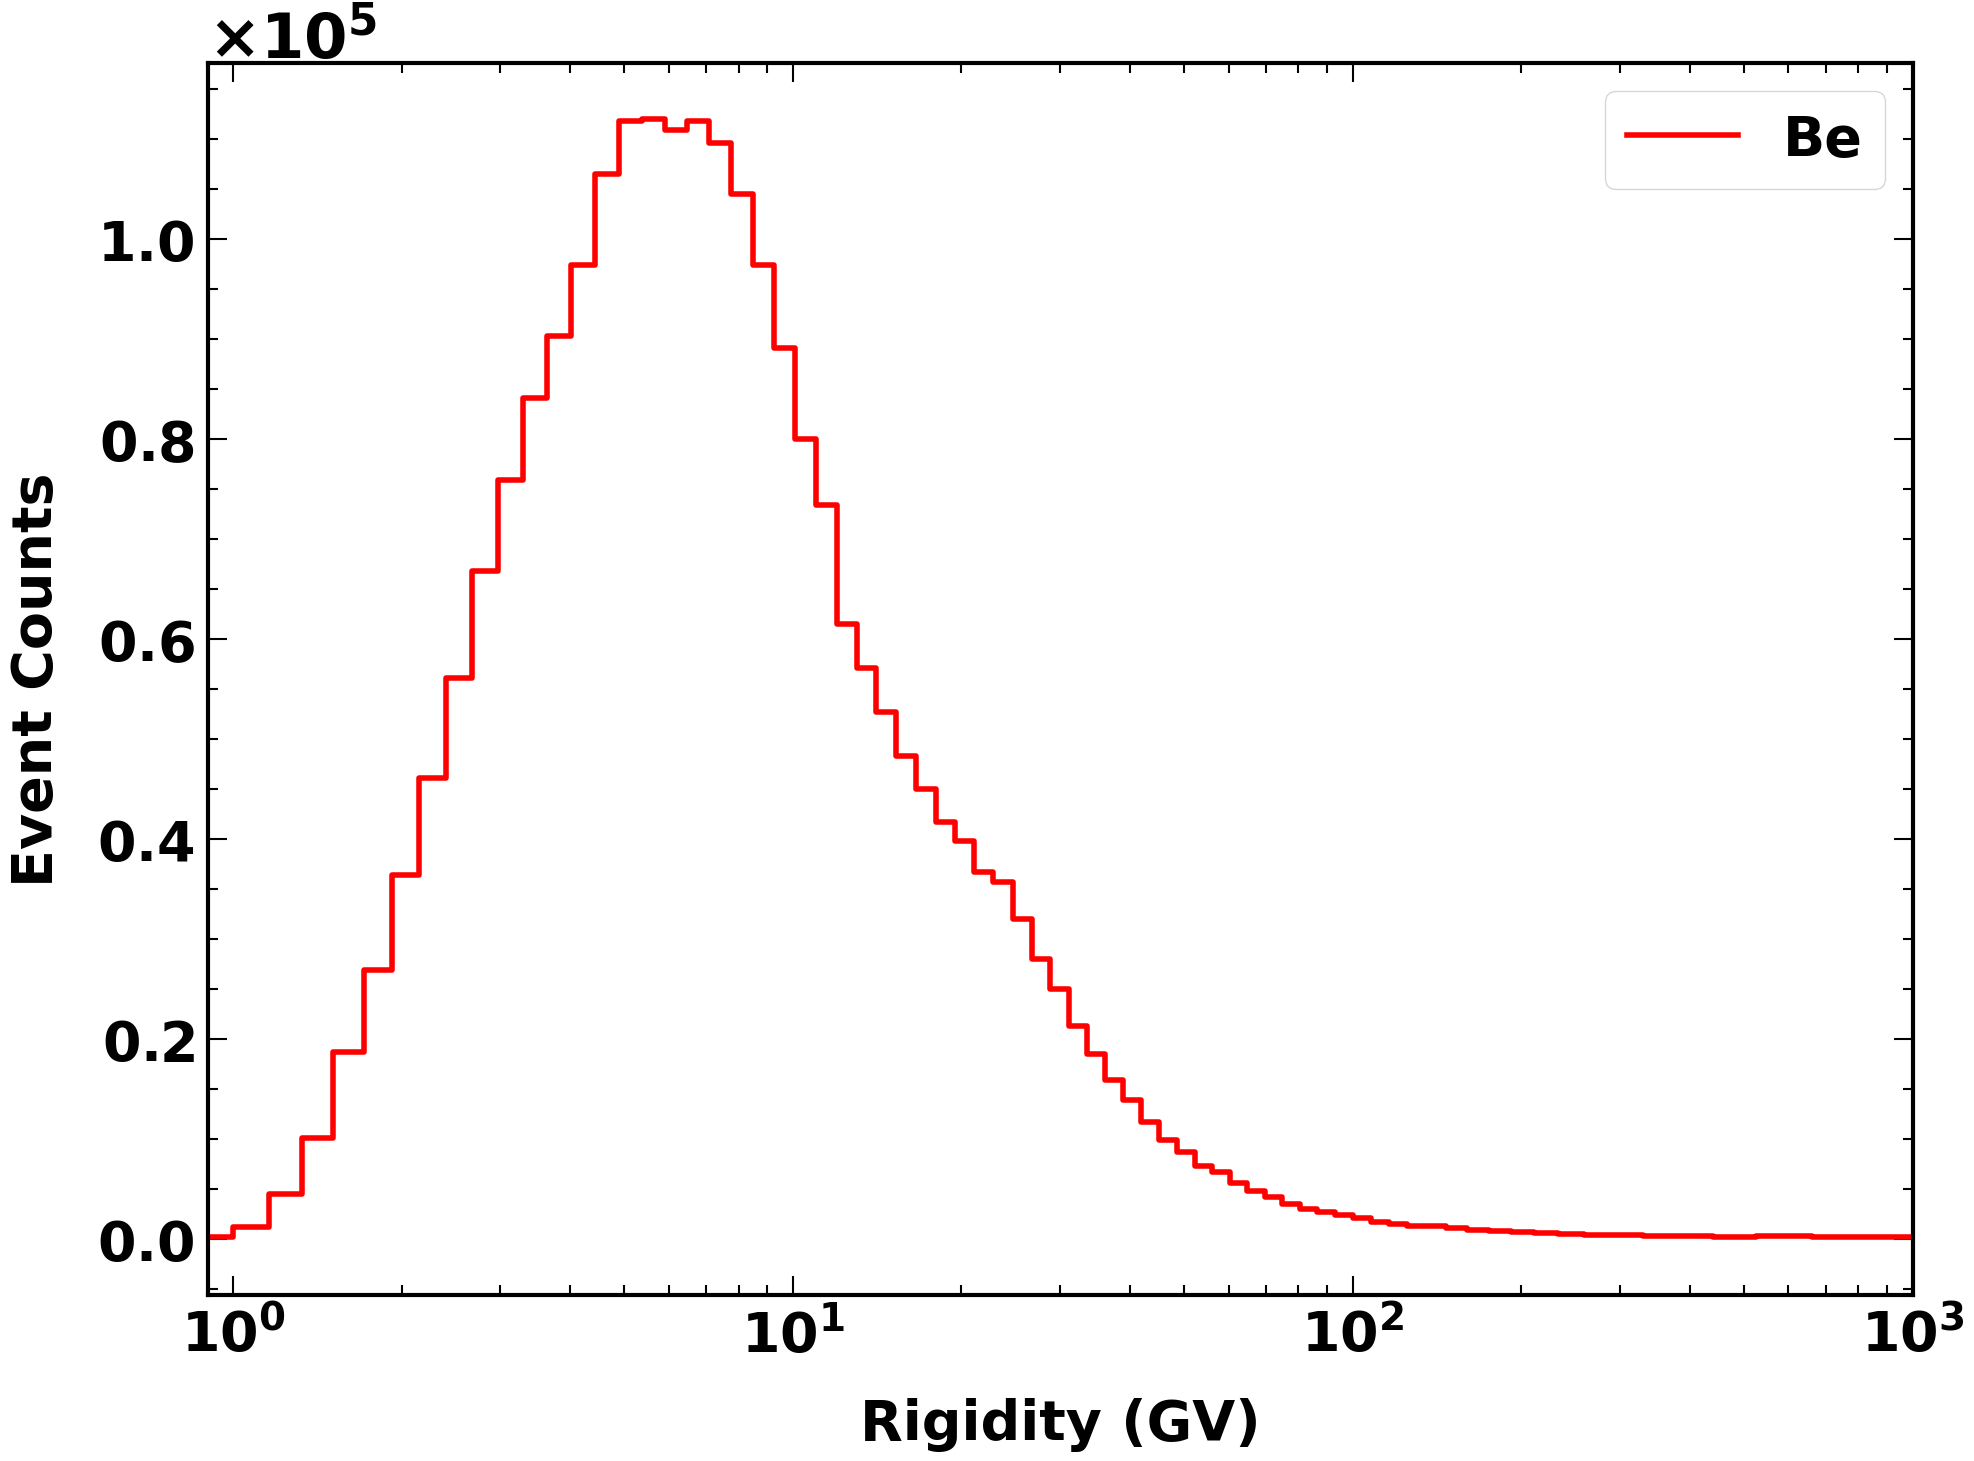

In [4]:
#Plot Event counts and rates
NUCLEI_COLOR = {'Be': 'red', 'Li':'tab:blue', 'B':'tab:orange'}

file_histmass_Bedata = '/home/manbing/Documents/Data/data_BeP8/presel_flux/BeISS_Rigidity_P8GBL_finebin11yr_countsVsR.npz'
file_histmass_Lidata = '/home/manbing/Documents/Data/data_LiP8/presel_flux/LiISS_Rigidity_P8GBL_finebin11yr_countsVsR.npz'
file_histmass_Bdata = '/home/manbing/Documents/Data/data_BP8/presel_flux/BISS_Rigidity_P8GBL_finebin11yr_countsVsR.npz'

dfcBe = np.load(f'{file_histmass_Bedata}')
dfcLi = np.load(f'{file_histmass_Lidata}')
dfcB = np.load(f'{file_histmass_Bdata}')
isotopes = ['Be7', 'Be9', 'Be10']
    
#for nuclei in ALLNUCLEI:
figure, ax1 = plt.subplots(1, 1, figsize=(22, 16))
hist_counts_Be = Histogram.from_file(dfcBe, f'hist_Be_countsVsR') 
hist_counts_Li = Histogram.from_file(dfcLi, f'hist_Li_countsVsR')   
hist_counts_B = Histogram.from_file(dfcB, f'hist_B_countsVsR')
plot_histogram_1d(ax1, hist_counts_Be, style="mc", color=NUCLEI_COLOR['Be'], label='Be', scale=None, gamma=None, xlog=True, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False, linewidth=4)
#plot_histogram_1d(ax1, hist_counts_Li, style="mc", color=NUCLEI_COLOR['Li'], label='Li', scale=None, gamma=None, xlog=True, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False, linewidth=2)
#plot_histogram_1d(ax1, hist_counts_B, style="mc", color=NUCLEI_COLOR['B'], label='Boron', scale=None, gamma=None, xlog=True, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False, linewidth=2)
print(hist_counts_Be.binnings[0].edges)
print(hist_counts_Be.values[1:-1].sum())
ax1.legend(fontsize=TEXTSIZE)
set_plot_style(ax1)
SetAx1Axis(ax1, 'Rigidity (GV)', 'Event Counts', TEXTSIZE, xlimrange=[0.9, 1000], ylimrange=None, custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/averageflux'
print(plotfile)
savefig_tofile(figure, plotfile, f"be_data_counts", show=True)


/tmp/ipykernel_221239/1863631267.py:4: RuntimeWarning: divide by zero encountered in divide
  Be_EventRate = hist_counts_Be.values[1:-1]/hist_time.values()
/tmp/ipykernel_221239/1863631267.py:5: RuntimeWarning: divide by zero encountered in divide
  Be_EventRate_err = np.sqrt(hist_counts_Be.values[1:-1])/hist_time.values()
/home/manbing/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


/home/manbing/Documents/lithiumanalysis/slides/plots/LiBeBoronAverageFlux


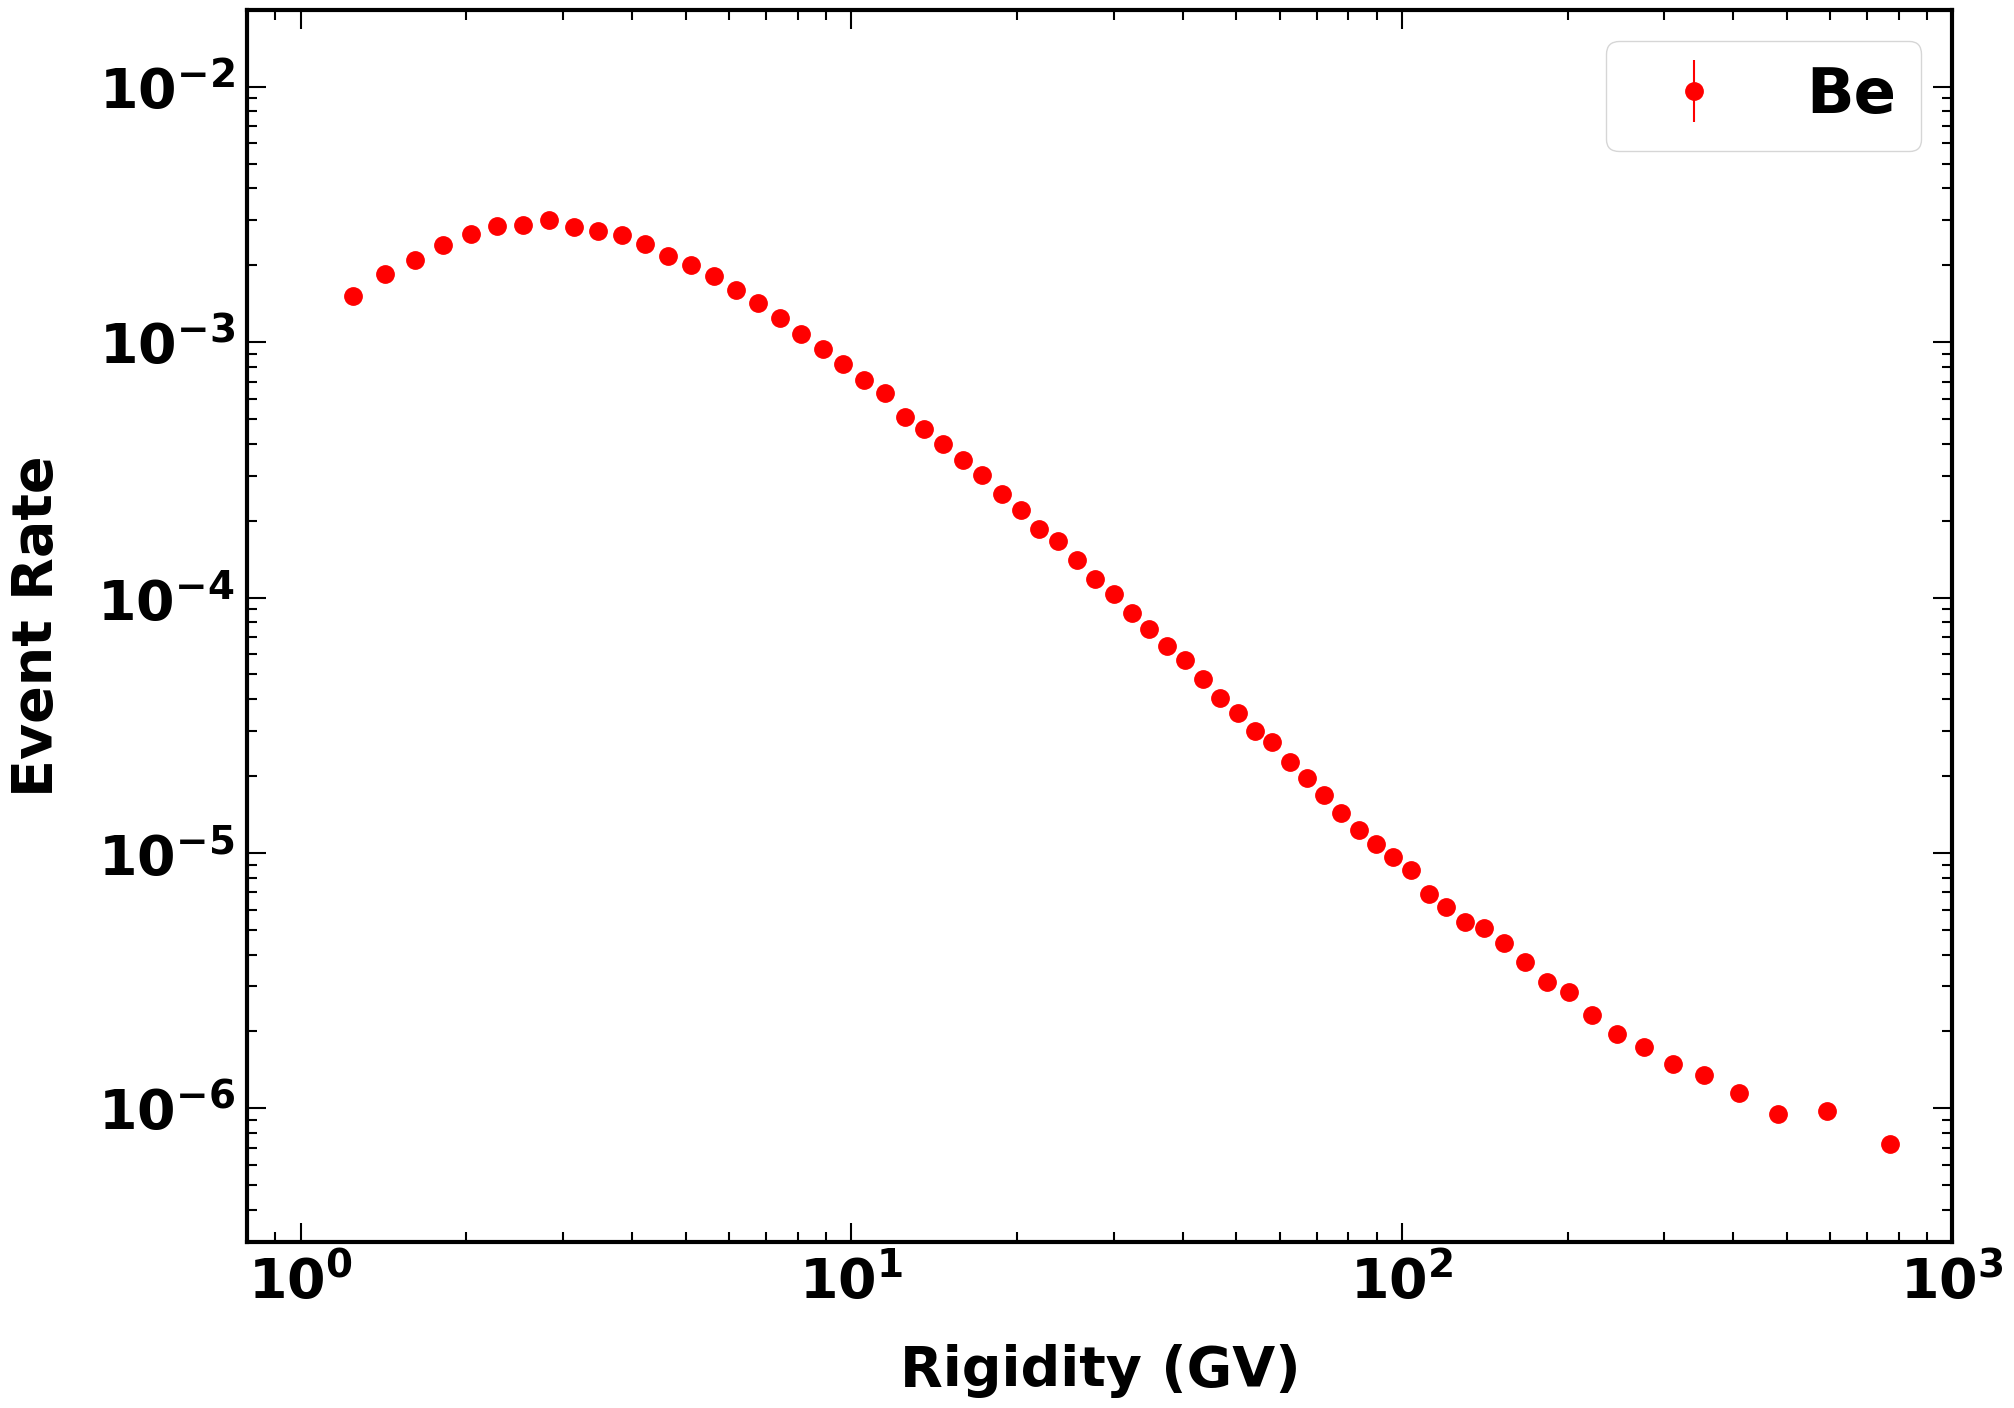

In [5]:
##################
#plot events rates
def get_event_rate(hist_counts_Be, hist_time):
    Be_EventRate = hist_counts_Be.values[1:-1]/hist_time.values()
    Be_EventRate_err = np.sqrt(hist_counts_Be.values[1:-1])/hist_time.values()

    graph_Be_eventrate = MGraph(hist_counts_Be.binnings[0].bin_centers[1:-1], Be_EventRate, Be_EventRate_err)
    return graph_Be_eventrate
    
graph_Be_eventrate = get_event_rate(hist_counts_Be, hist_time)
graph_Li_eventrate = get_event_rate(hist_counts_Li, hist_time)
graph_B_eventrate = get_event_rate(hist_counts_B, hist_time)


fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))
plot_graph(fig, ax1,graph_Be_eventrate, color=NUCLEI_COLOR['Be'],  style="EP", xlog=True, ylog=True, scale=None, markersize=25, label='Be')
#plot_graph(fig, ax1,graph_Li_eventrate, color=NUCLEI_COLOR['Li'],  style="EP", xlog=True, ylog=True, scale=None, markersize=25, label='Li')
#plot_graph(fig, ax1,graph_B_eventrate, color=NUCLEI_COLOR['B'],  style="EP", xlog=True, ylog=True, scale=None, markersize=25, label='Boron')
set_plot_style(ax1)
ax1.legend()
SetAx1Axis(ax1, 'Rigidity (GV)', 'Event Rate', TEXTSIZE, xlimrange=[0.8, 1000], ylimrange=[0.0000003, 0.02], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=False)
print(plotfile)
savefig_tofile(fig, plotfile, f"be_data_rates", show=True)

/home/manbing/Documents/Data/data_BeP8/presel_flux/BeMC_dict_graph_rawacc_RigidityP8.npz


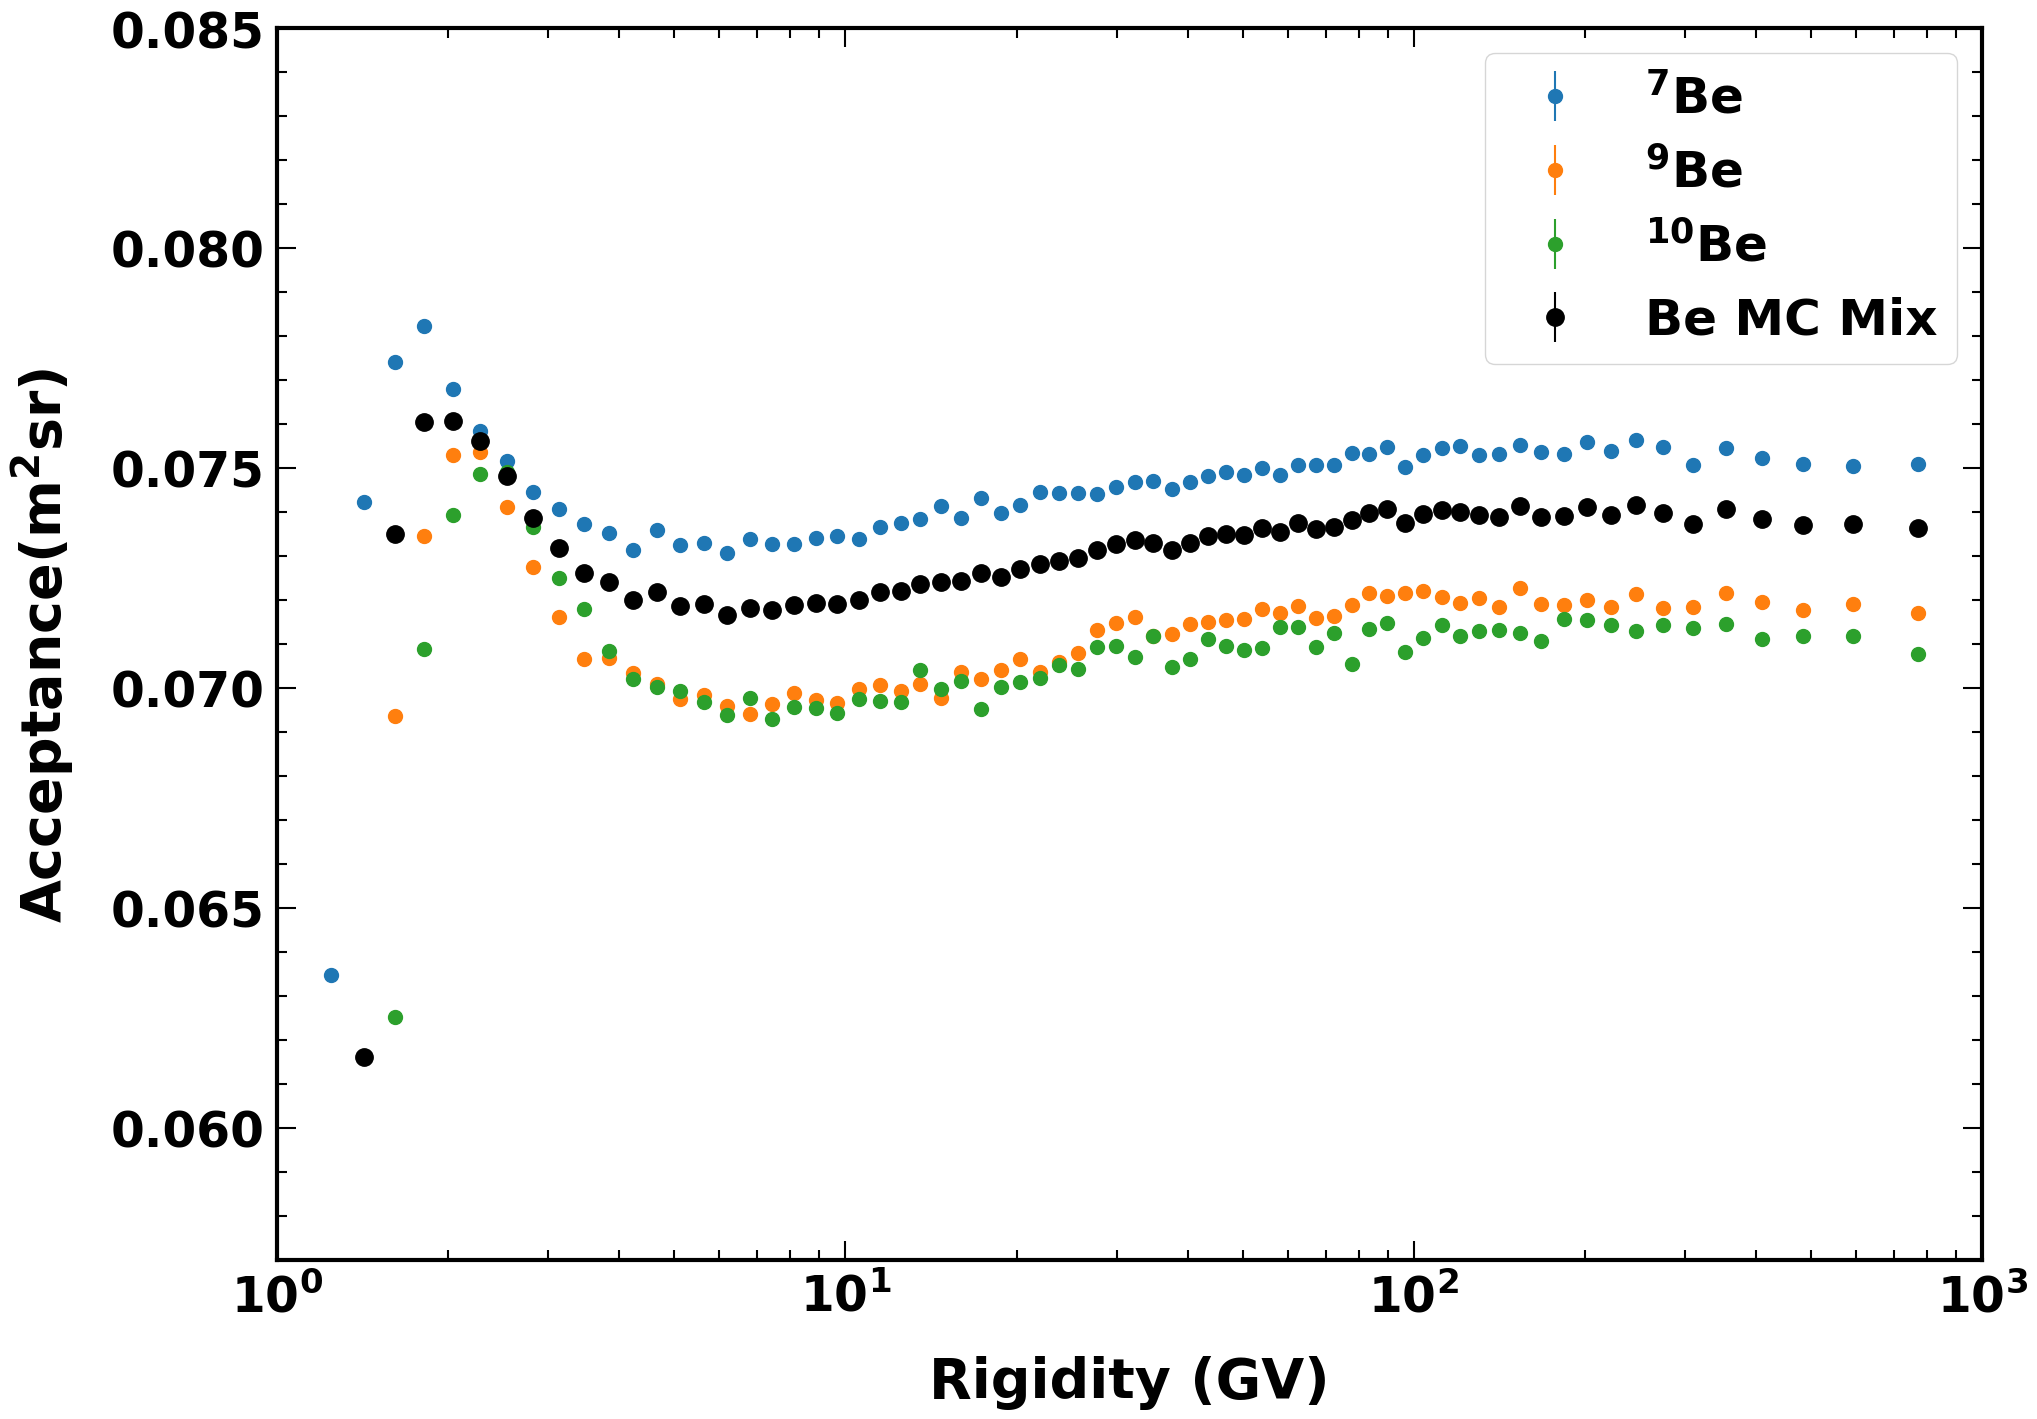

In [6]:
nuclei = 'Be'
print(file_acc['Be'])
df_acc = np.load(file_acc['Be'])       
graph_accraw = {dec: {iso: MGraph.from_file(df_acc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES[nuclei]} for dec in detectors}                                                                              
    
ylim_range = {'Tof': [0.057, 0.085], "NaF": [0.003, 0.008], "Agl": [0.02, 0.05]}
xlim_range = {'Be7': [1.9, 1000],  'Be9': [2.1, 1000], 'Be10': [2.5, 1000]}
subgraph_acc =  {dec: {} for dec in detectors}
spline_subgraph_acc =  {dec: {} for dec in detectors}
graph_acc_fromspline = {dec: {} for dec in detectors}

graph_averageaccraw = {}
grahp_my_countsoveracc = {}
subgraph_avgaccraw = {}
spline_avgaccraw = {}
for dec in detectors:
    avgacc = 0.6 * graph_accraw[dec]['Be7'].yvalues + 0.3 * graph_accraw[dec]['Be9'].yvalues + 0.1*graph_accraw[dec]['Be10'].yvalues
    avgaccerr  = 0.6 * graph_accraw[dec]['Be7'].yerrs + 0.3 * graph_accraw[dec]['Be9'].yerrs + 0.1*graph_accraw[dec]['Be10'].yerrs
    graph_averageaccraw[dec] = MGraph(graph_accraw[dec]['Be7'].xvalues, avgacc, avgaccerr)
    
    #fig, ax1 = plt.subplots(1, 1, figsize=FIGSIZE2)
    #plot_graph(fig, ax1,graph_averageaccraw[dec] , color=NUCLEI_COLOR['Be'],  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='Be MC')
    #set_plot_style(ax1)
    #SetAx1Axis(ax1, 'Rigidity (GV)', 'Acceptance', TEXTSIZE, xlimrange=[1.5, 1000], ylimrange=[0.03, 0.1], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=False)
    #ax1.text(0.1, 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black', fontweight="bold")      
    #ax1.legend()

for dec in ['Tof']:                                                                                                                                                                                          
    figure, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                        
    for i, iso in enumerate(ISOTOPES[nuclei]): 
        subgraph_acc[dec][iso] = slice_graph_by_value(graph_accraw[dec][iso], xlim_range[iso])
        x_values = subgraph_acc[dec][iso].xvalues
        spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, k=5, s=5)  
        
        #ax1.plot(x_values, spline_subgraph_acc[dec][iso](np.log(x_values)))
        #acc_corr = graph_acc[dec][iso].yvalues * graph_total_effcor_ekin[dec][iso].yvalues                                                                                                                     
        #graph_corrected_acc[dec][iso] = MGraph(xbinning["Ekin"].bin_centers[1:-1], acc_corr, graph_acc[dec][iso].yerrs)                                                                                                                                                                                                                                                                                                  
        plot_graph(figure, ax1, graph_accraw[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{ISO_LABELS[iso]}", style="EP", xlog=True, ylog=False, markersize=20)                                                                            
        #plot_graph(figure, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                    
        
        set_plot_style(ax1)
        SetAx1Axis(ax1, 'Rigidity (GV)', r"$\mathrm{Acceptance \ (m^{2} sr)}$", TEXTSIZE, xlimrange=[1.0, 1000], ylimrange=ylim_range[dec], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)
        ax1.set_ylabel(r"$\mathrm{Acceptance (m^{2} sr)}$")                                                                                                                                                    
        #ax1.text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')   
    plot_graph(figure, ax1,graph_averageaccraw[dec], color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='Be MC Mix')
    ax1.legend()  
    #plotfile='/home/manbing/Documents/lithiumanalysis/thesis/images/averageflux'
    savefig_tofile(figure, plotfile, f"Acc{nuclei}_{variable}_P8B1236", 1)                                                                                          
    

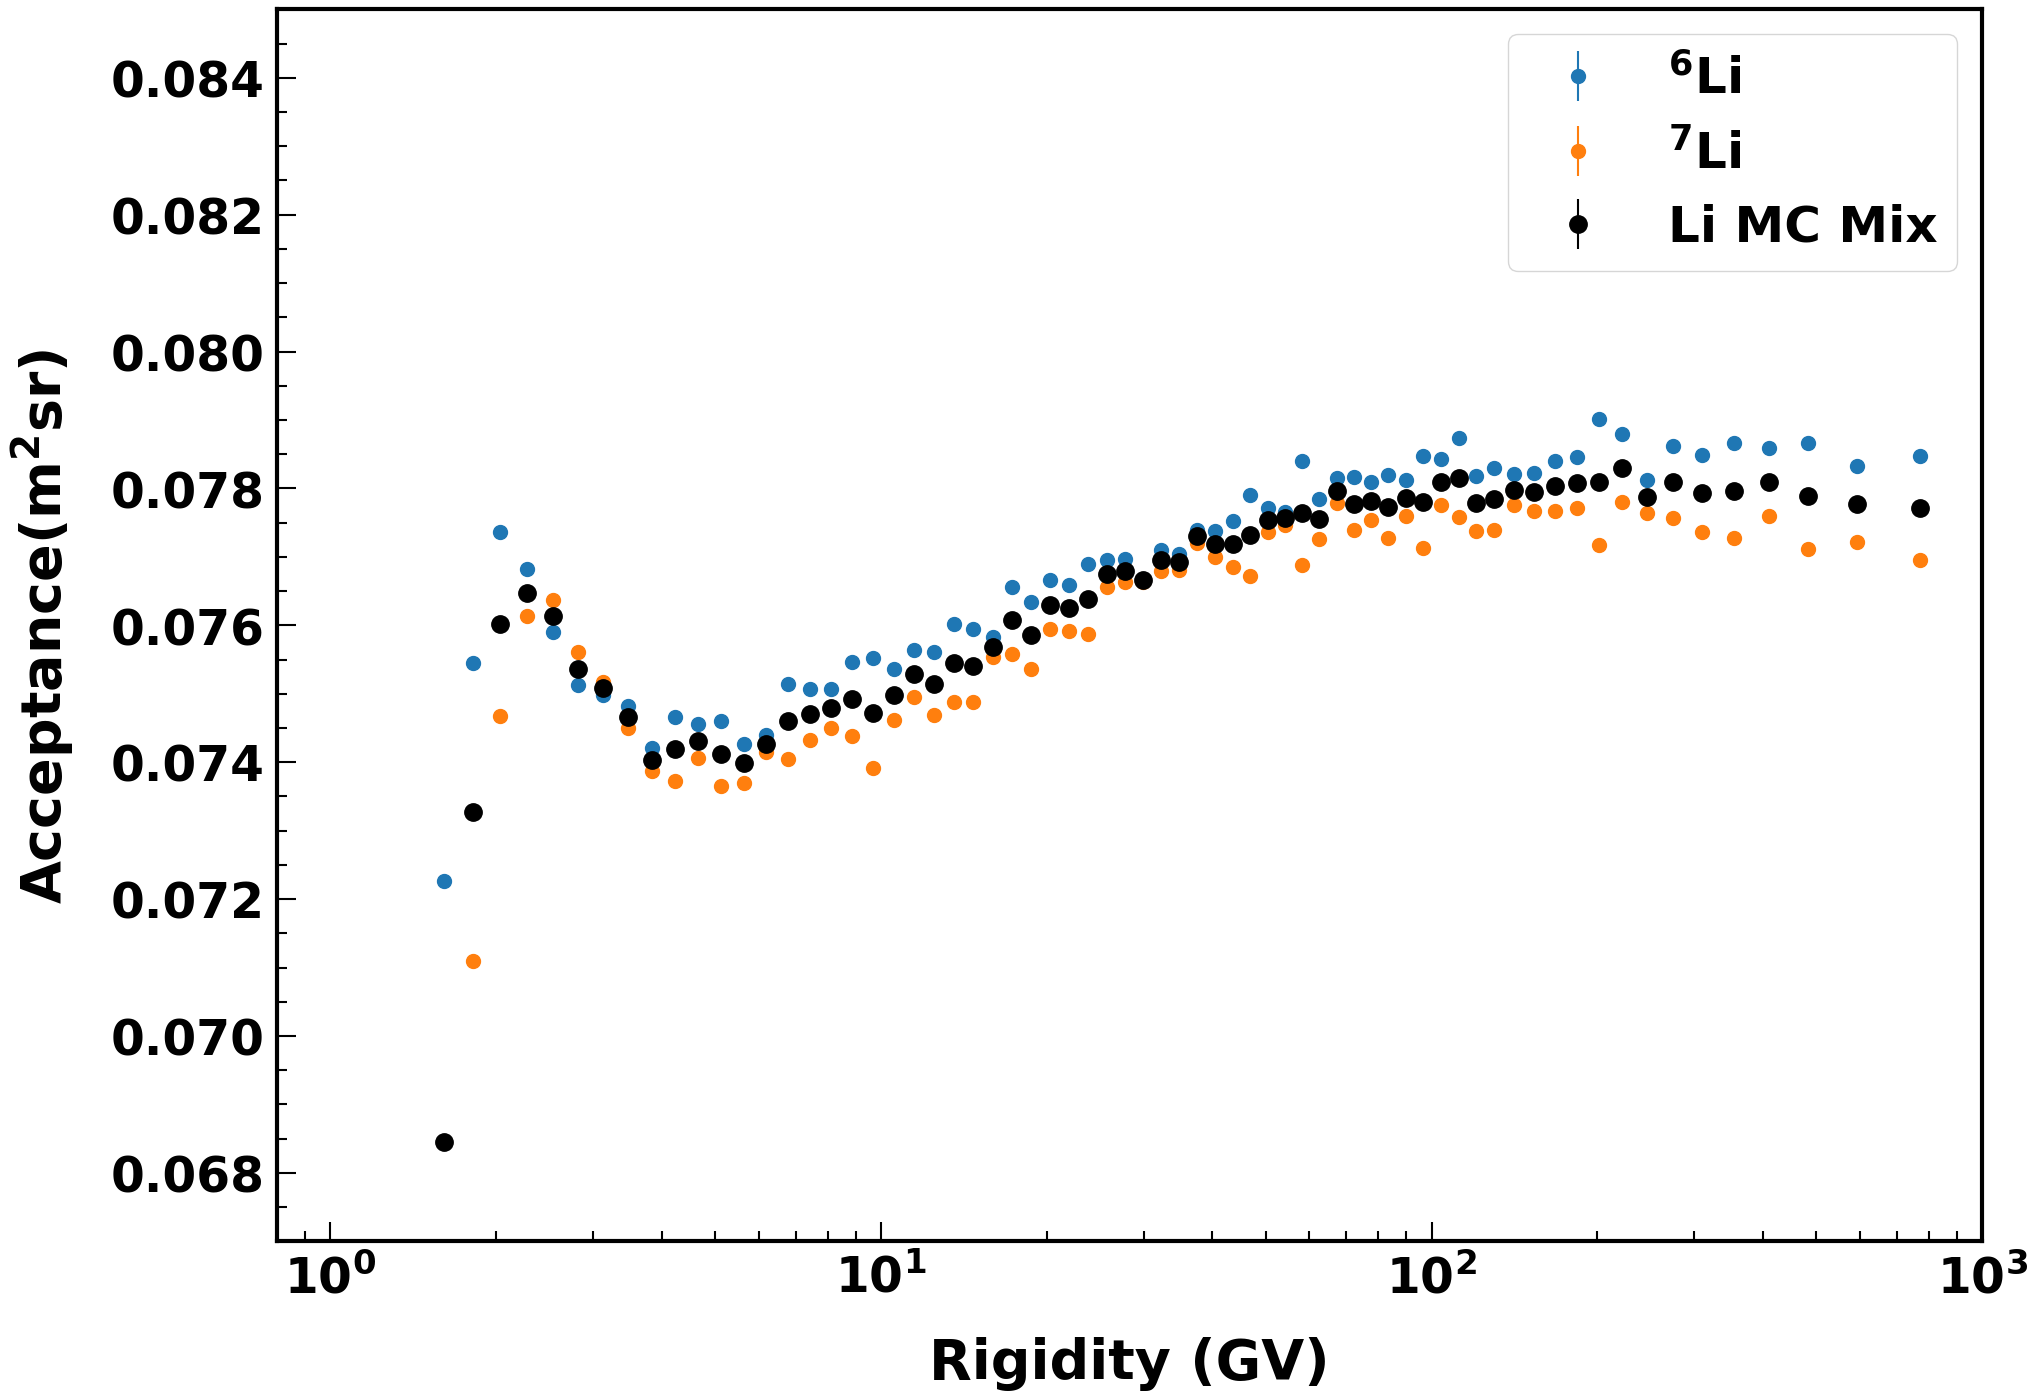

In [7]:
file_acc_Li = '/home/manbing/Documents/Data/data_LiP8/presel_flux/LiMC_dict_graph_rawacc_RigidityP8.npz'
nuclei = 'Li'
df_acc = np.load(file_acc['Li'])       
graph_accraw_Li = {dec: {iso: MGraph.from_file(df_acc, f"raw_acc_{dec}_{iso}") for iso in ISOTOPES['Li']} for dec in detectors}                                                                              
ylim_range = {'Tof': [0.067, 0.085], "NaF": [0.003, 0.008], "Agl": [0.02, 0.05]}
xlim_range = {'Li6': [2.0, 1000],  'Li7': [2.5, 1000], 'Be10': [2.1, 1000]}
subgraph_acc =  {dec: {} for dec in detectors}
spline_subgraph_acc =  {dec: {} for dec in detectors}
graph_acc_fromspline = {dec: {} for dec in detectors}

graph_averageaccraw = {}
grahp_my_countsoveracc = {}
subgraph_avgaccraw = {}
spline_avgaccraw = {}
for dec in detectors:
    avgacc = 0.5 * graph_accraw_Li[dec]['Li6'].yvalues + 0.5 * graph_accraw_Li[dec]['Li7'].yvalues 
    avgaccerr  = 0.5 * graph_accraw_Li[dec]['Li6'].yerrs + 0.5 * graph_accraw_Li[dec]['Li7'].yerrs 
    graph_averageaccraw[dec] = MGraph(graph_accraw_Li[dec]['Li6'].xvalues, avgacc, avgaccerr)
    

for dec in ['Tof']:                                                                                                                                                                                          
    figure, ax1 = plt.subplots(1, 1, figsize=(22, 16))                                                                                                        
    for i, iso in enumerate(ISOTOPES['Li']): 
        subgraph_acc[dec][iso] = slice_graph_by_value(graph_accraw_Li[dec][iso], xlim_range[iso])
        x_values = subgraph_acc[dec][iso].xvalues
        spline_subgraph_acc[dec][iso] = UnivariateSpline(np.log(subgraph_acc[dec][iso].xvalues),subgraph_acc[dec][iso].yvalues, k=5, s=5)  
        #ax1.plot(x_values, spline_subgraph_acc[dec][iso](np.log(x_values)))
        #acc_corr = graph_acc[dec][iso].yvalues * graph_total_effcor_ekin[dec][iso].yvalues                                                                                                                     
        #graph_corrected_acc[dec][iso] = MGraph(xbinning["Ekin"].bin_centers[1:-1], acc_corr, graph_acc[dec][iso].yerrs)                                                                                                                                                                                                                                                                                                  
        plot_graph(figure, ax1, graph_accraw_Li[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{ISO_LABELS[iso]}", style="EP", xlog=True, ylog=False, markersize=20)                                                                            
        #plot_graph(figure, ax1, graph_corrected_acc[dec][iso], color=ISOTOPES_COLOR[iso], label=f"{iso}", style="EP", xlog=True, ylog=False, markersize=20)                                                    
        set_plot_style(ax1)
        SetAx1Axis(ax1, 'Rigidity (GV)', r"$\mathrm{Acceptance \ (m^{2} sr)}$", TEXTSIZE, xlimrange=[0.8, 1000], ylimrange=ylim_range[dec], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)
        ax1.set_ylabel(r"$\mathrm{Acceptance (m^{2} sr)}$")                                                                                                                                                    
        #ax1.text(0.05, 0.98, f"{dec}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')         
    plot_graph(figure, ax1,graph_averageaccraw[dec], color='black',  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='Li MC Mix')
    ax1.legend() 
    #plotfile='/home/manbing/Documents/lithiumanalysis/thesis/images/averageflux'
    savefig_tofile(figure, plotfile, f"Acc{nuclei}_{variable}_P8B1236", 1)                                                                                          
    

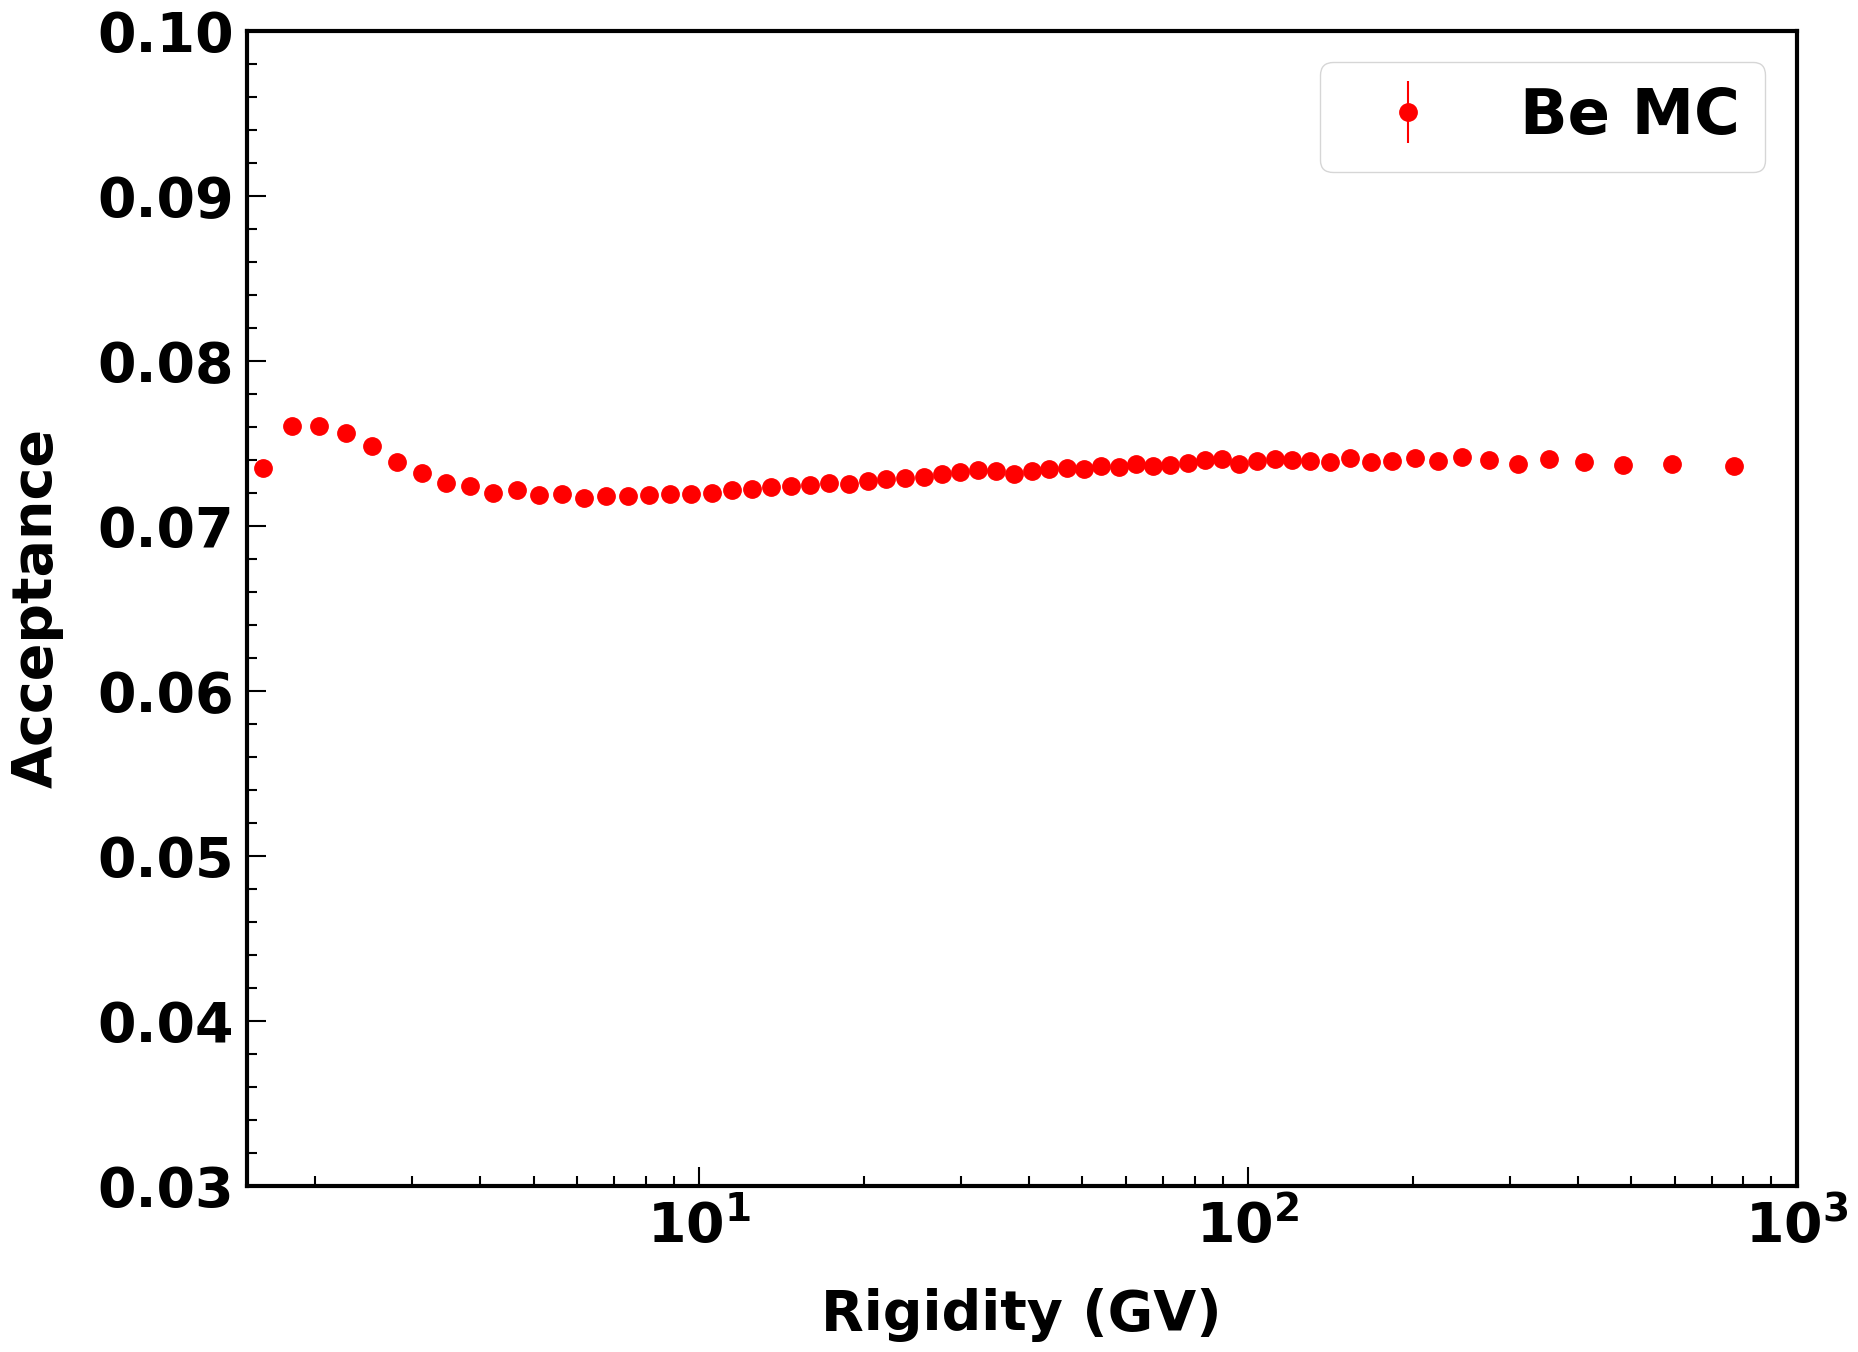

In [8]:
graph_averageaccraw = {}
grahp_my_countsoveracc = {}
subgraph_avgaccraw = {}
spline_avgaccraw = {}
for dec in detectors:
    avgacc = 0.6 * graph_accraw[dec]['Be7'].yvalues + 0.3 * graph_accraw[dec]['Be9'].yvalues + 0.1*graph_accraw[dec]['Be10'].yvalues
    avgaccerr  = 0.6 * graph_accraw[dec]['Be7'].yerrs + 0.3 * graph_accraw[dec]['Be9'].yerrs + 0.1*graph_accraw[dec]['Be10'].yerrs
    graph_averageaccraw[dec] = MGraph(graph_accraw[dec]['Be7'].xvalues, avgacc, avgaccerr)
    
    fig, ax1 = plt.subplots(1, 1, figsize=FIGSIZE2)
    plot_graph(fig, ax1,graph_averageaccraw[dec] , color=NUCLEI_COLOR['Be'],  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='Be MC')
    set_plot_style(ax1)
    SetAx1Axis(ax1, 'Rigidity (GV)', 'Acceptance', TEXTSIZE, xlimrange=[1.5, 1000], ylimrange=[0.03, 0.1], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=False)
    #ax1.text(0.1, 0.98, f"{dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black', fontweight="bold")      
    ax1.legend()


['graph_total_effcor_tof_xvalues', 'graph_total_effcor_tof_yvalues', 'graph_total_effcor_tof_yerrs', 'graph_total_effcor_tof_labels']


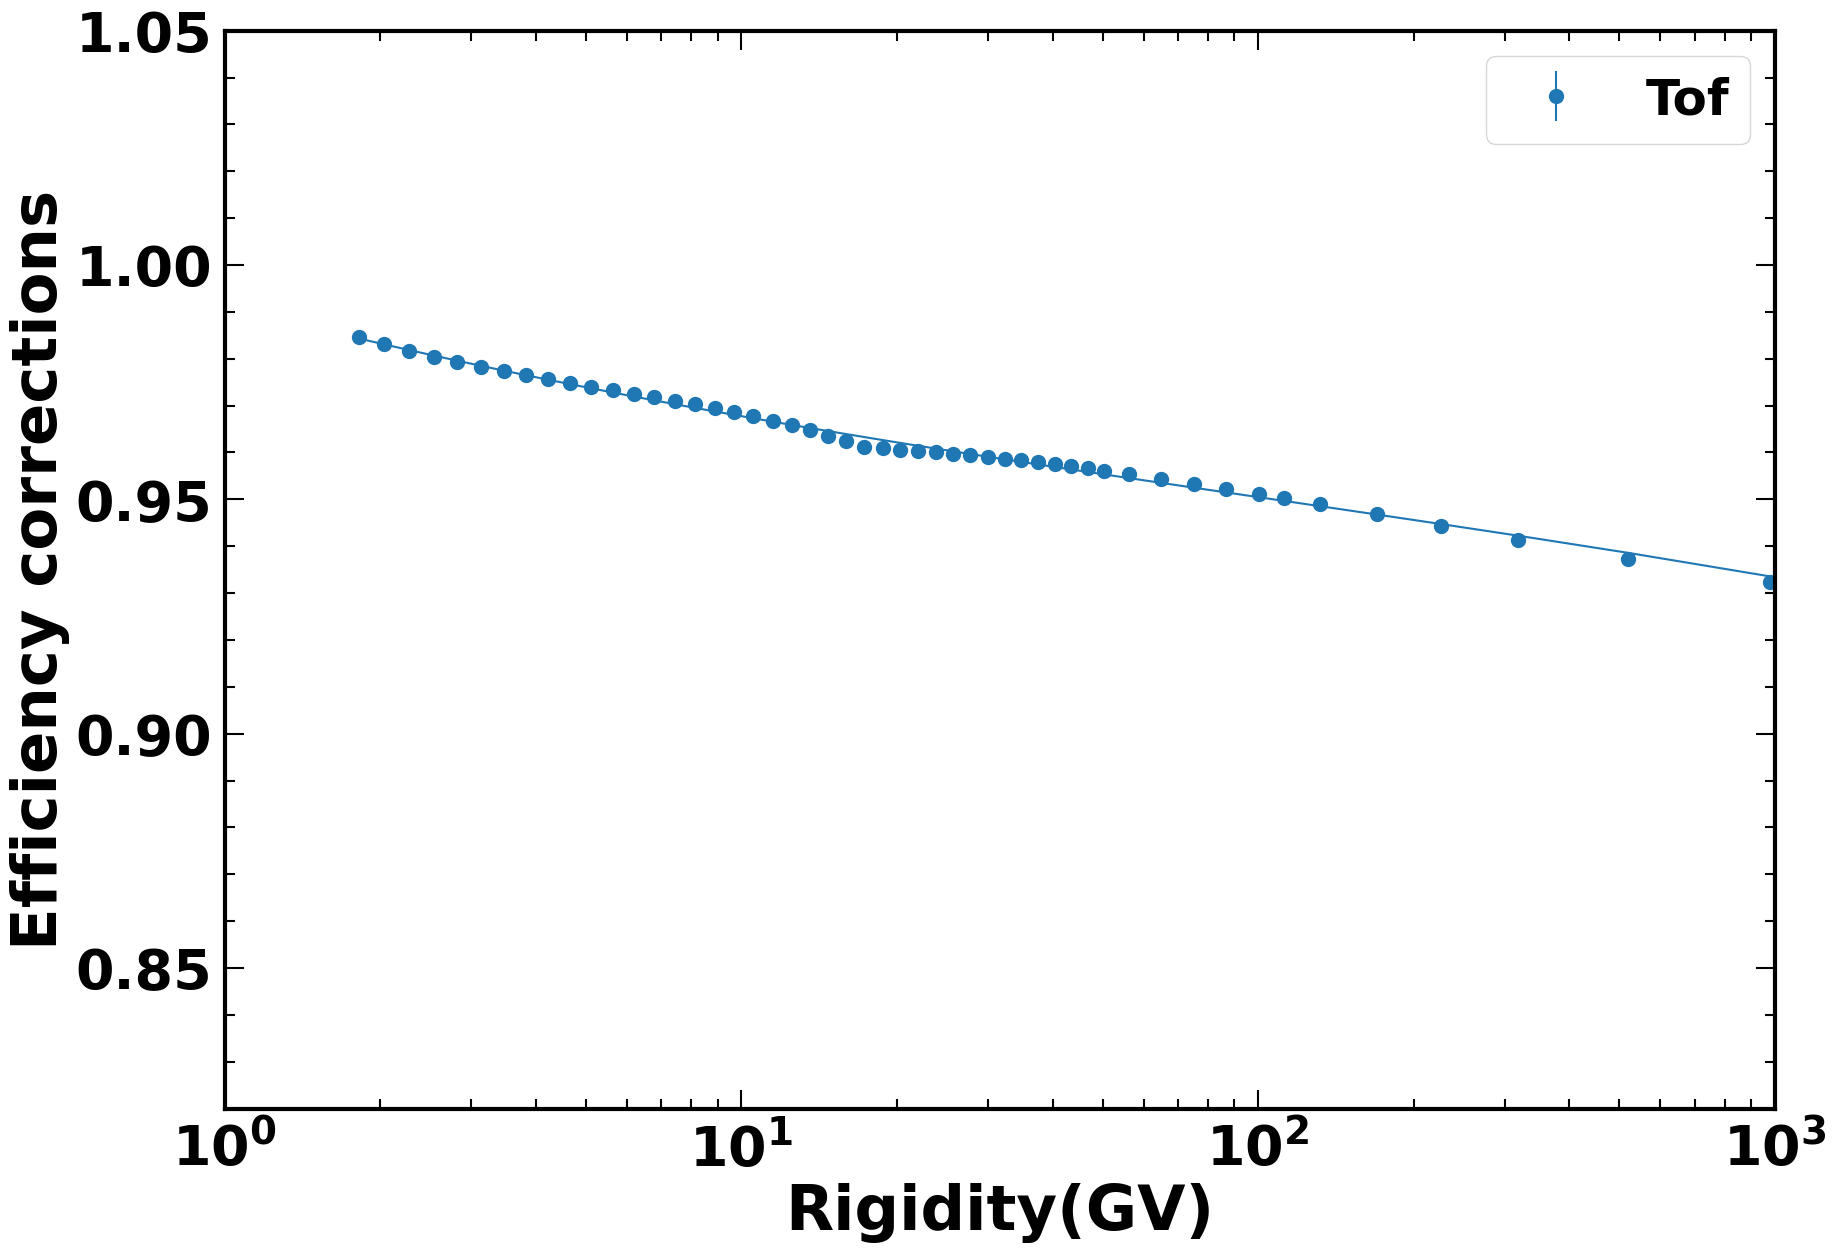

In [9]:
df_effcor = np.load(f'{file_effcor["Be"]}')
print(list(df_effcor.keys()))
graph_total_effcor = dict()
spline_total_effcor = dict()
rigidity_range = {'Tof':[1.8, 3000], 'NaF':[2.9, 16], 'Agl':[5, 36]}
for dec in ['Tof']:
    graph_total_effcor[dec] = MGraph.from_file(df_effcor, f'graph_total_effcor_{detectors_alias[dec]}')
    graph_total_effcor[dec] = slice_graph_by_value(graph_total_effcor[dec], rigidity_range[dec])
    spline_total_effcor[dec] = UnivariateSpline(np.log(graph_total_effcor[dec].xvalues),graph_total_effcor[dec].yvalues, k=3, s=5)           

figure, ax1 = plt.subplots(1, 1, figsize=(20, 14))         
for dec in detectors:
    plot_graph(figure, ax1, graph_total_effcor[dec], color=DETECTOR_COLOR[dec], label=f"{dec}", style="EP", xlog=True, ylog=False, markersize=20)
    ax1.plot(graph_total_effcor[dec].xvalues, spline_total_effcor[dec](np.log(graph_total_effcor[dec].xvalues)), '-', color=DETECTOR_COLOR[dec])
    ax1.set_xlim([1, 1000])
    ax1.legend()
    ax1.set_ylim([0.82, 1.05])
    ax1.set_xlabel('Rigidity(GV)')
    ax1.set_ylabel('Efficiency corrections')
    set_plot_style(ax1)
savefig_tofile(figure, plotfile, f"effcor_{variable}_P7B1220_vsR", 1)   
  

################################################################################################ <br>
####compute the raw flux with counts from the fit <font color="red">all paremeters free</font>  
#################################################################################################

In [10]:
def read_hist_from_rootfile(rootfile, histname):
    with uproot.open(rootfile) as file:
        myhist = file[histname]
        thisgraph = MGraph(get_bin_center(myhist.axes[0].edges()), myhist.values(), myhist.errors())
    return myhist, thisgraph


    
def get_fluxTimesR27(graphflux):
    graphfluxR27 = MGraph(graphflux.xvalues, graphflux.yvalues, graphflux.yerrs)
    graphfluxR27.yvalues = graphflux.yvalues * graphflux.xvalues**2.7
    graphfluxR27.yerrs = graphflux.yerrs * graphflux.xvalues**2.7
    return graphfluxR27

/home/manbing/Documents/lithiumanalysis/slides/plots/LiBeBoronAverageFlux


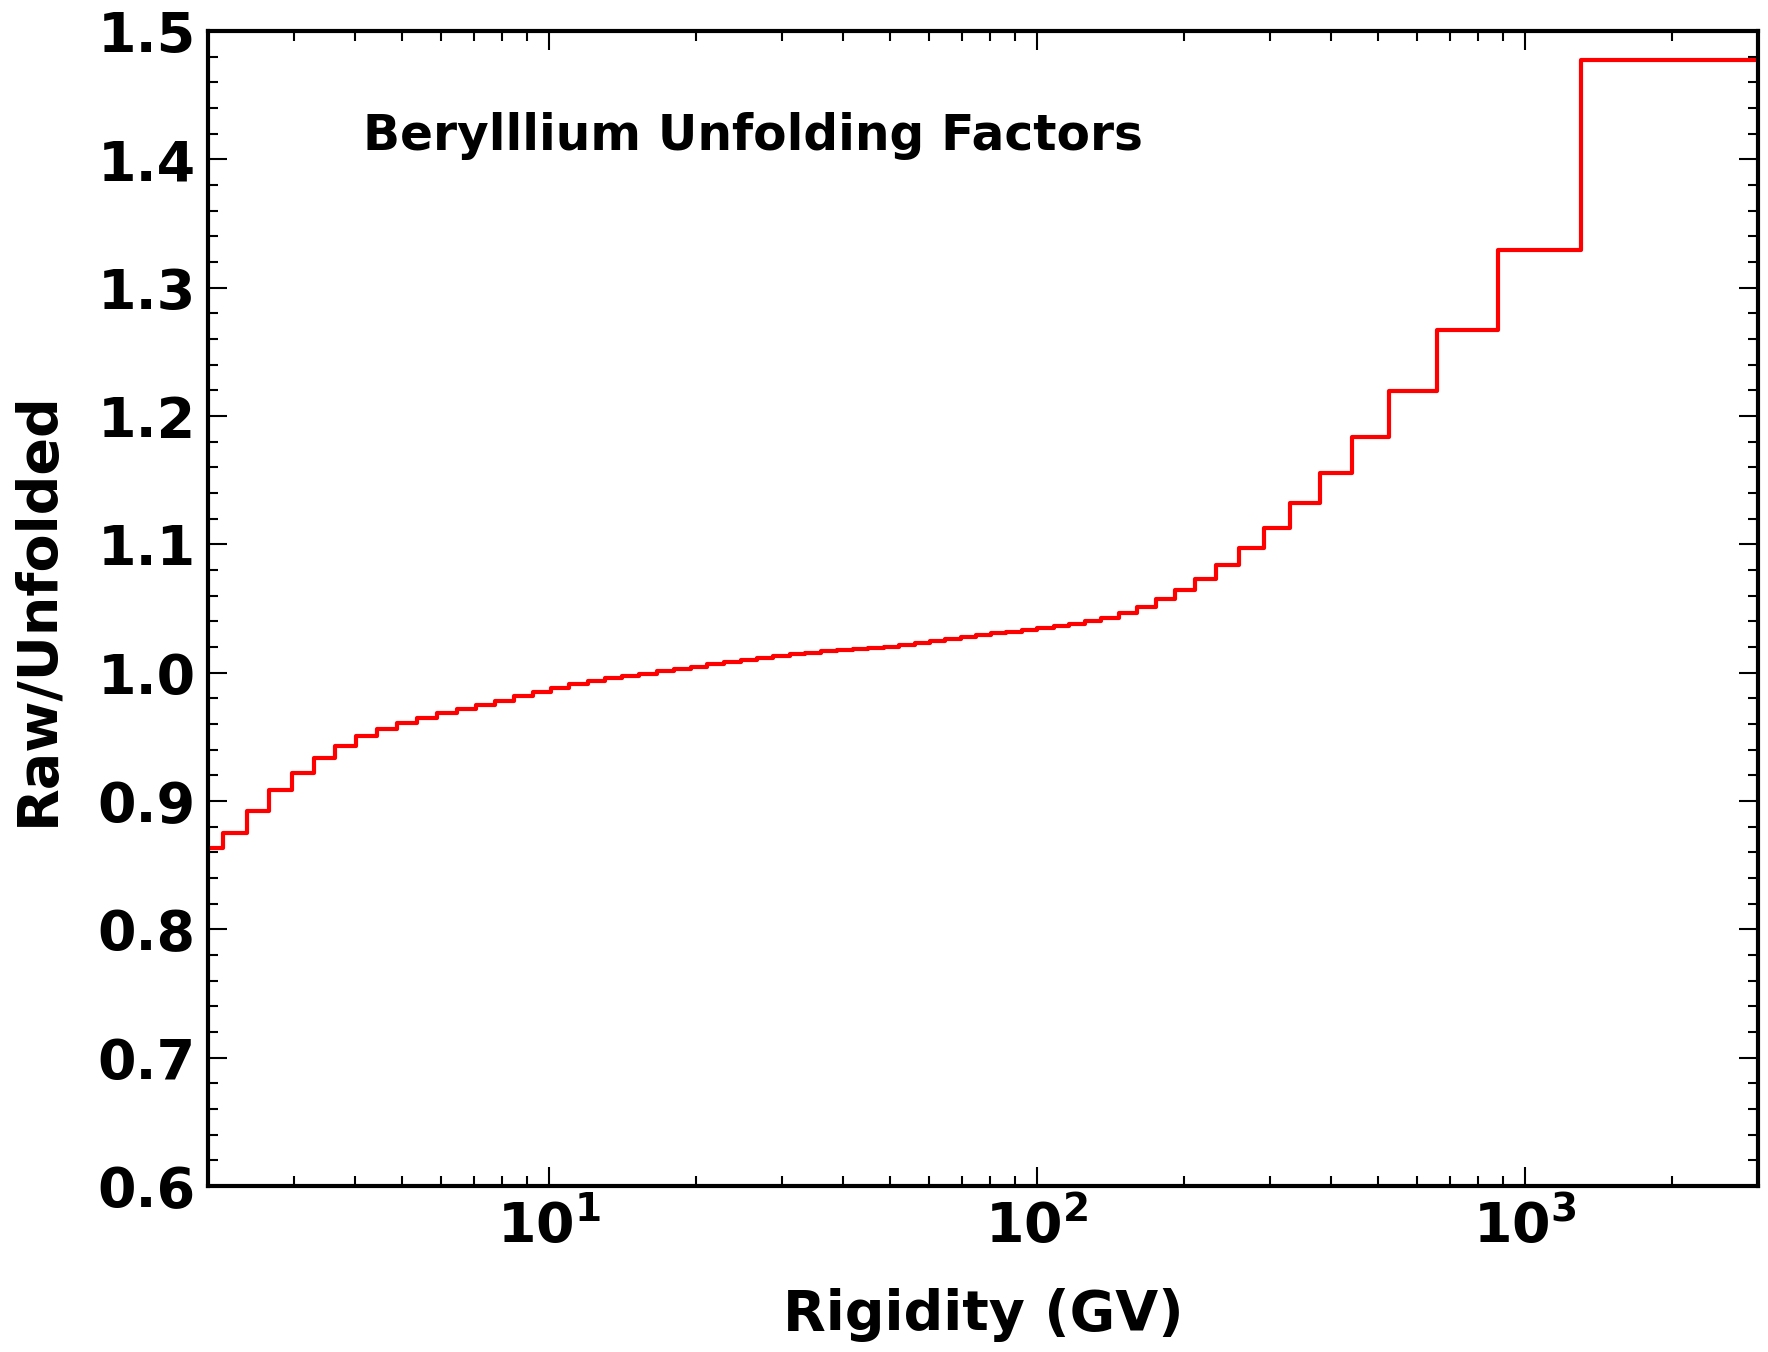

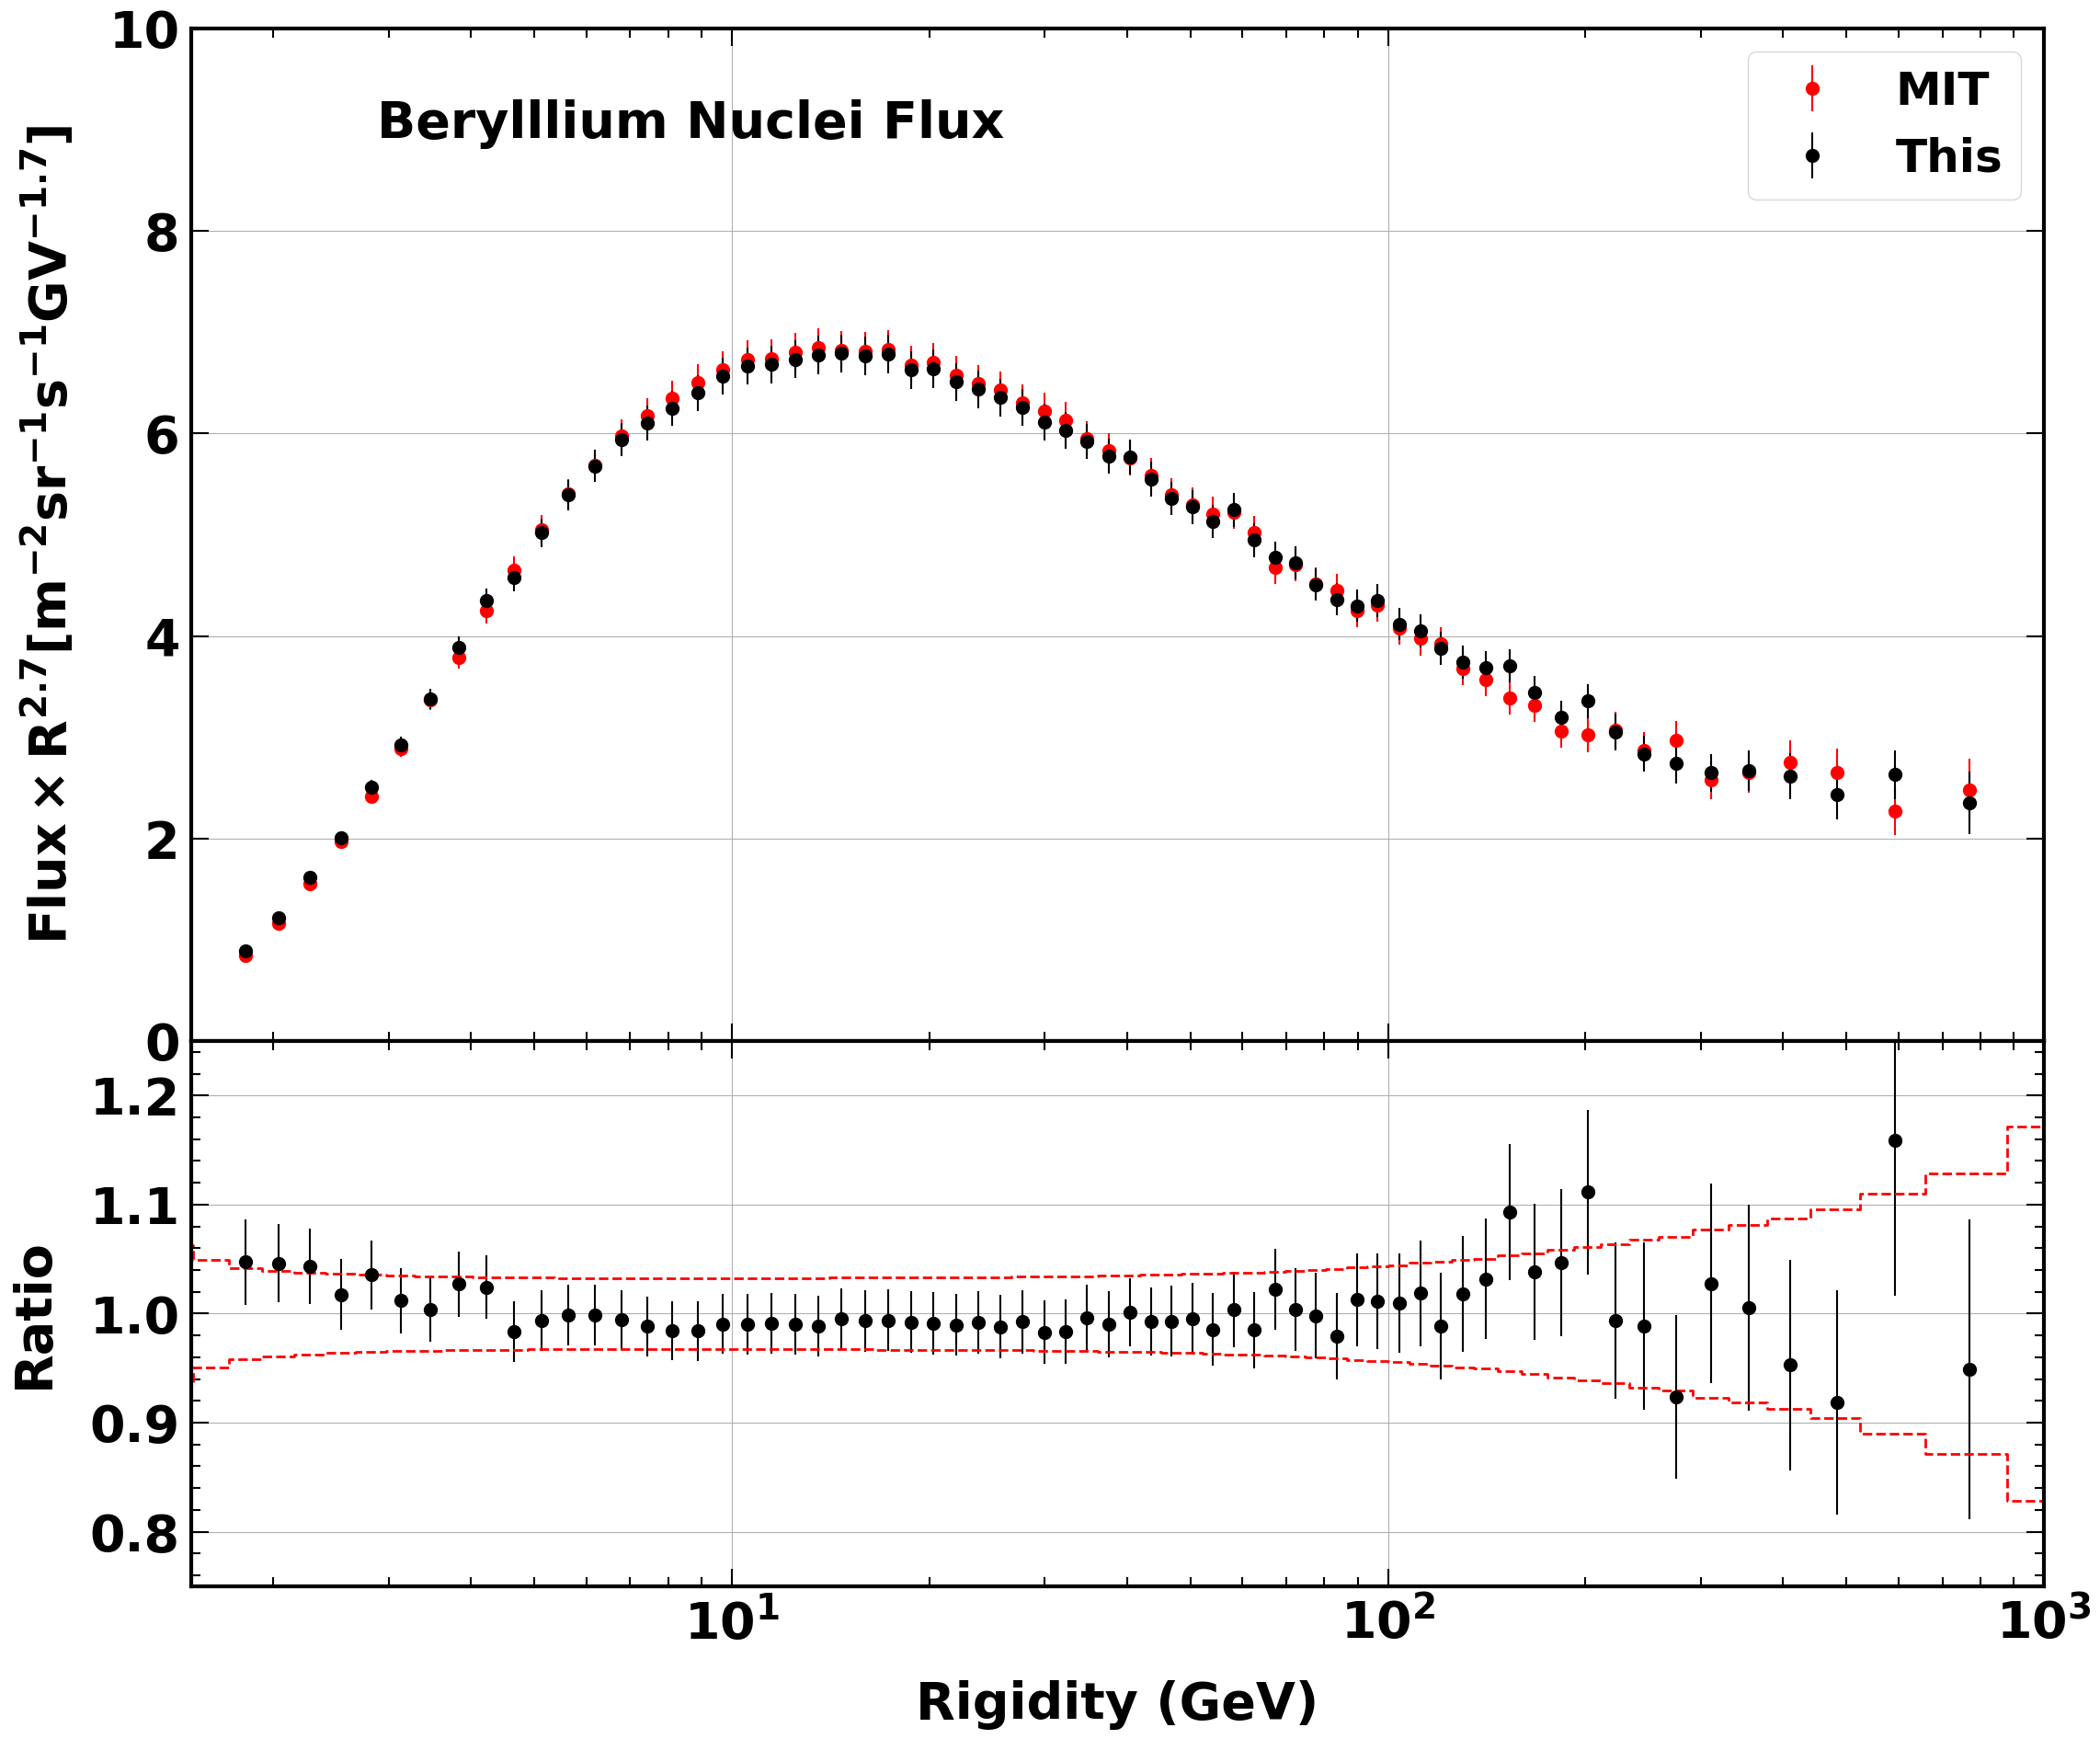

In [11]:
graph_flux_raw = {}
graph_unfoldflux = {}
df_rawflux = dict() 
df_unfoldflux = dict()
subgraph_unfoldfactor = {}
graph_unfoldflux_timesR = {}
data_dict ={dec:  dict() for dec in detectors}

filefluxqy2 = '/home/manbing/Documents/Data/data_BeP8/presel_flux/beryllium68_20230304P8_B1236602R4MCKY11YJCOMBUNFOLDTOINB_totalQYAN.root'
#filefluxqy2 = '/home/manbing/Documents/Data/data_flux_qy/beryllium64_20200420V2N_B1219401R4MCKY10COMBUNFOLDTOINB_totalQYAN.root'
rhist_unfold, graph_unfoldqy = read_hist_from_rootfile(filefluxqy2, 'RawVUnfoldN')

sebin = hist_counts_Be.binnings[0].get_indices([1.8, 1000])
graph_counts_Be = MGraph(hist_counts_Be.binnings[0].bin_centers[sebin[0]:sebin[1]], hist_counts_Be.values[sebin[0]:sebin[1]], np.sqrt(hist_counts_Be.values[sebin[0]:sebin[1]]))

for dec in detectors:     

    graph_counts =graph_counts_Be
    xenergy = graph_counts.xvalues      
    
    
    graph_accraw = slice_graph_by_value(graph_averageaccraw[dec], [xenergy[0], xenergy[-1]])  
    #graph_accraw = MGraph(xenergy, spline_subgraph_acc[dec][iso](np.log(xenergy)), 0.01*spline_subgraph_acc[dec][iso](np.log(xenergy)))
    graph_time = slice_graph_by_value(graph_measuretime, [xenergy[0], xenergy[-1]]) 
    graph_effcor = MGraph(xenergy, spline_total_effcor[dec](np.log(xenergy)), np.zeros_like(xenergy))

    subgraph_unfoldqy = slice_graph_by_value(graph_unfoldqy, [xenergy[0], xenergy[-1]]) 
    #graph_unfold = MGraph(xenergy, spline_unfoldfactor[iso](np.log(xenergy)), np.zeros_like(xenergy))
    graph_unfold = subgraph_unfoldqy
    unfold_factor = graph_unfold.yvalues
    counts = graph_counts.yvalues                                                                                                                                                               
    counts_err = graph_counts.yerrs                                                                                                                                                              
    effcor = graph_effcor.yvalues
    acc = graph_accraw.yvalues
    acc_err = graph_accraw.yerrs

    
    indices = xbinning[variable].get_indices([xenergy[0], xenergy[-1]])                                                                                                                                    
    #bin_widths = xbinning.bin_widths[indices[0]: indices[1]+1]                                                                                                                                  
    bin_edges = xbinning[variable].edges[indices[0]: indices[1]+2]   
    bin_widths = bin_edges[1:] - bin_edges[:-1]  

    assert (np.all(xenergy == graph_effcor.xvalues))                                                                                                                                                                                                                                                                                                                             
    assert (np.all(xenergy == graph_time.xvalues))                                                                                                                                                               
    assert (np.all(xenergy == get_bin_center(bin_edges)))    
    assert (np.all(xenergy == graph_accraw.xvalues))
    #assert (np.all(xenergy == graph_unfold.xvalues))

    flux_raw = counts / (effcor * acc *graph_time.yvalues * bin_widths)                                                                                                                               
    flux_raw_err = flux_raw * np.sqrt((counts_err/counts)**2 + (acc_err/acc)**2)                                                                                                                         
    graph_flux_raw[dec] = MGraph(xenergy, flux_raw, flux_raw_err)                                                                                                                                                 
    graph_flux_raw[dec].add_to_file(df_rawflux, f'graph_rawflux_{dec}')

    unfoldflux = flux_raw / graph_unfold.yvalues
    unfoldfluxerr = flux_raw_err / graph_unfold.yvalues
    graph_unfoldflux[dec] = MGraph(xenergy, unfoldflux, unfoldfluxerr)
    
    graph_unfoldflux_timesR[dec] = get_fluxTimesR27(graph_unfoldflux[dec])
    
isoylim={'Be7': [0.001, 0.5], 'Be9':[0.0005, 0.5], 'Be10':[0.0001, 0.1]}

fileflux_qy = datadirP8['Be'] + 'beryllium68_20230304P8_B1236602R4MCKY11YJCOMBUNFOLDTOINB_totalQYAN.root'

with uproot.open(fileflux_qy) as fileqy:  
    hist_fluxqy = fileqy['Z4fluxh_totalN']
    
    yfluxqy = hist_fluxqy.values()                           
    xfluxqy = hist_fluxqy.axes[0].edges() 
    hist_fluxqy_totalerr = fileqy['total_e']
    graph_fluxqy = MGraph(get_bin_center(xfluxqy), yfluxqy, hist_fluxqy.errors()) 
   
    
fig, ax1 = plt.subplots(1, 1, figsize=FIGSIZE2)
#plot_graph(fig, ax1, graph_unfold, color=NUCLEI_COLOR['Be'],  style="EP", xlog=True, ylog=False, scale=None, markersize=25, label='Be')
xbin_unfold = rhist_unfold.axes[0].edges()[1:-1]
ydata_unfold= rhist_unfold.values()[1:-1]
ax1.step(np.concatenate(([xbin_unfold[0]], xbin_unfold)), np.concatenate(([0], ydata_unfold, [0])), where="post", color='red', label='unfold', linewidth=3) 
ax1.text(0.1, 0.93, f"Berylllium Unfolding Factors", fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')         
subgraph_fluxqy = slice_graph_by_value(graph_fluxqy, [graph_flux_raw['Tof'].xvalues[0], graph_flux_raw['Tof'].xvalues[-1]])
#plot_graph(fig, ax1, subgraph_fluxqy, color='black',  style="EP", xlog=True, ylog=True, scale=None, markersize=25, label='Be QY')
set_plot_style(ax1)
SetAx1Axis(ax1, 'Rigidity (GV)', 'Raw/Unfolded', TEXTSIZE, xlimrange=[2, 3000], ylimrange=[0.6, 1.5], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)  
savefig_tofile(fig, plotfile, f'be_unfoldfactor_{figname}', 1)


graph_qyflux_timesR = get_fluxTimesR27(subgraph_fluxqy)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.65, 0.35]}, figsize=FIGSIZE_X12)

plot_graph(fig, ax1, graph_qyflux_timesR, color='red', style="EP", xlog=True, ylog=False, markersize=20, label='MIT')
graph_unfoldflux_timesR[dec].yerrs = graph_qyflux_timesR.yerrs
plot_graph(fig, ax1, graph_unfoldflux_timesR[dec], color='black', style="EP", xlog=True, ylog=False, markersize=20, label=f'This')

plot_graph(fig, ax2, graph_unfoldflux[dec]/subgraph_fluxqy, color='black', style="EP", xlog=True, ylog=False, markersize=20, label='this/QY')
#plot_graph(fig, ax2, graph_unfoldflux_timesR[dec]/graph_qyflux_timesR, color='black', style="EP", xlog=True, ylog=False, markersize=20, label='this/QY')
ax1.legend()
set_plot_style(ax1)
set_plot_style(ax2)

ax1.text(0.1, 0.93, f"Berylllium Nuclei Flux", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", weight='bold')         

xbin_err = hist_fluxqy_totalerr.axes[0].edges()[1:-1]
ydata_errUp= hist_fluxqy_totalerr.values()[1:-1] +1.005
ydata_errLow= 0.995 - hist_fluxqy_totalerr.values()[1:-1] 
ax2.step(np.concatenate(([xbin_err[0]], xbin_err)), np.concatenate(([0], ydata_errUp, [0])), where="post", color='red', label=None, linewidth=2, linestyle='--') 
ax2.step(np.concatenate(([xbin_err[0]], xbin_err)), np.concatenate(([0], ydata_errLow, [0])), where="post", color='red', label=None, linewidth=2, linestyle='--') 


SetAx1Ax2Xaxis(ax1, ax2, 'Rigidity (GeV)', TEXTSIZE,  xlimrange=[1.5, 1000], custom_ticks=None, custom_tickslabels=None, gridx1=True,  gridx2=True, xscale=None)
SetAx1Ax2Yaxis(ax1, ax2, r'$\mathrm{Flux \times R^{2.7} [m^{-2}sr^{-1}s^{-1}GV^{-1.7}]}$', 'Ratio', TEXTSIZE, ylimrange1=[0, 10],  ylimrange2=[0.75, 1.25], gridy1=True,  gridy2=True)


print(plotfile)
savefig_tofile(fig, plotfile, f'be_nucleiflux_{figname}', 1)